### Chapter Two Solution
#### 2.1
**Answer**

The probability to select the greedy one is 1-$\epsilon$ plus the probability in the random part, which is $\frac{\epsilon}{2}$ since there is only 2 actions. 
$$
    1 - \epsilon + \frac{\epsilon}{2} = 0.75
$$

#### 2.2
**Answer**

On the time step that the reward got is less than the greedy action's, $\epsilon$ case definitely occurs, on the ones that the rewards are the same, $\epsilon$ case may occurs.
So on time steps 2,5, $\epsilon$ case must occur, and in other steps it may occur.
    
#### 2.3
**Answer**

The case that $\epsilon = 0.01$ will be better, because the asymptomatic limit of the two case are different, shown below.
    $$
        \lim_{t\to\infty}Q_t^{\epsilon=0.1}(a) = 1-\epsilon+\frac{\epsilon}{10} = 0.91\\
        \lim_{t\to\infty}Q_t^{\epsilon=0.01}(a) = 1-\epsilon+\frac{\epsilon}{10} = 0.991
    $$
    
#### 2.4
**Answer**

Let $\alpha_0 = 1$, then 
\begin{equation}
    Q_{n + 1} = \left(\prod_{i=1}^n (1 - \alpha_i) \right) Q_1 + \sum_{i = 1}^{n}  \alpha_{i} R_{i} \prod_{k = i + 1}^n
(1 - \alpha_k).
\end{equation}
Where $\prod_{i=x}^y f(i) \doteq 1$ if $x > y$.
#### 2.5

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib notebook

In [91]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, incremental = False,true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.incremental = incremental
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial
        
        self.q_total = np.zeros(self.k)

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                     self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        return np.argmax(self.q_estimation)

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.average_reward = (self.time - 1.0) / self.time * self.average_reward + reward / self.time
        self.action_count[action] += 1
        self.q_total[action] += reward
        
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += 1.0 / self.action_count[action] * (reward - self.q_estimation[action])
        elif self.incremental:
            self.q_estimation[action] = self.q_total[action]/self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation = self.q_estimation + self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward
    
def simulate(runs, time, bandits):
    '''
        @runs is to take average and get a more accurate result
    '''
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in tqdm(range(runs)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

In [25]:
def q_2_5():
    epsilon = 0.1
    alpha = 0.1
    runs = 1000
    steps = 10000
    bandits = []
    bandits.append(Bandit(sample_averages=True,epsilon=epsilon))
    bandits.append(Bandit(incremental=True,epsilon=epsilon))
    bandits.append(Bandit(step_size=alpha))
    best_action_counts, rewards = simulate(runs, steps, bandits)
    labels = ["sample average","incrementally computed","step-size = %.2f"%alpha]
    plt.figure(figsize=(10,20))
    plt.title("epsilon = %.2f" % epsilon)
    plt.subplot(2,1,1)
    plt.xlabel("step")
    plt.ylabel("average reward")
    for label, reward in zip(labels,rewards):
        plt.plot(reward, label=label)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel("step")
    plt.ylabel("% optimal action")
    for label, counts in zip(labels,best_action_counts):
        plt.plot(counts, label=label)
    plt.legend()
    plt.savefig("./img/2-5.png")

**Answer**

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.06it/s]


<IPython.core.display.Javascript object>


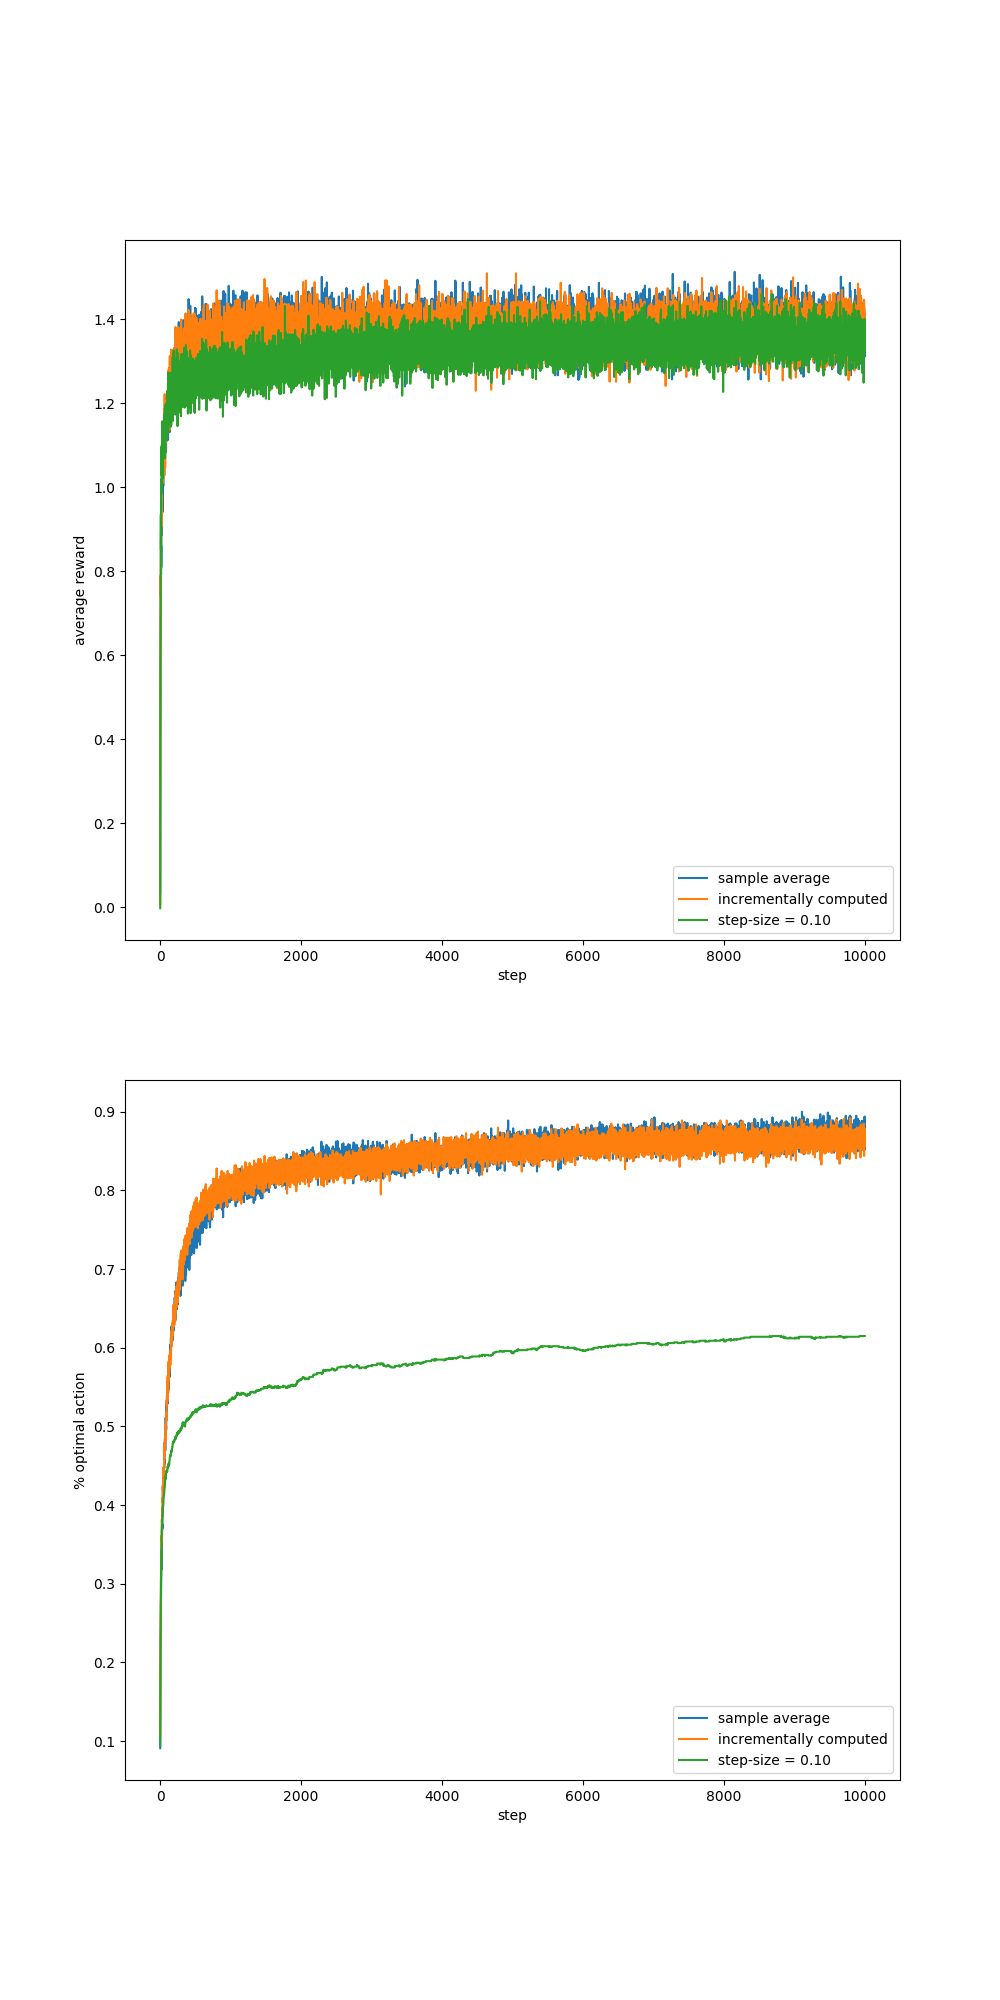

In [22]:
q_2_5()

#### 2.6
**Answer**

The magnitude of the reward given will lead to the oscillation and spike. Because the reward is quite small than 5, the agent will find a optimal action after several exploration, and choosing the optimal action a few times, but the value of that action decrease, so the agent choose another "optimal" action again.

#### 2.7
**Answer**

\begin{equation}
    Q_{n + 1} = \left(\prod_{i=1}^n (1 - \beta_i) \right) Q_1 + \sum_{i = 1}^{n}  \beta_{i} R_{i} \prod_{k = i + 1}^n
(1 - \beta_k).\\
    \bar{o}_{n} = \sum_{i=0}^{n-1}\alpha{(1-\alpha)}^i = 1-{(1-\alpha)}^n
\end{equation}
$Q_{n}$ is without bias because $Q_{1}$ is 1, and it is decreasing since $\beta_{n}$ is decreasing.

### 2.8
**Answer**

In the first 10 steps the agent cycles through all of the actions because when $N_t(a) = 0$ then $a$ is considered maximal. On the 11th step the agent will most often then choose greedily. The agent will continue to choose greedily until $\mathrm{ln}(t)$ overtakes $N_t(a)$ for one of the other actions, in which case the agent begins to explore again hence reducing rewards.

### 2.9
**Answer**
\begin{equation}
    P{}(A_t = 1) = \frac{e^{H_t(1)}}{e^{H_t(1)} + e^{H_t(0)}} = \frac{1}{1 + e^{-x}}, 
\end{equation}
where $x = H_t(1) - H_t(0)$ is the relative preference of 1 over 0.

### 2.10
**Answer**

In the first case, the expectation rewards are both 0.5 for both actions, so the choice is not important.

As in the UCB method, I can use the frequency to solve this problem. Just chose
$$
    arg\max_{a}\frac{1}{2} - \frac{t}{N_{t}(a)}
$$
the expectation is 0.55.

### 2.11

In [95]:
def q_2_11():
    runs = 1000
    steps = 5000
    bandits = []
    generators = [lambda epsilon: Bandit(epsilon=epsilon, incremental=True),
                  lambda epsilon: Bandit(epsilon=epsilon, step_size=0.1)]
    parameter = np.arange(-10,0,dtype=np.float)
    for generator in generators:
        for para in parameter:
            bandits.append(generator(2**para))
    _,rewards = simulate(runs, steps, bandits)
    average_rewards = np.mean(rewards, axis=1)
    labels = [u"$\epsilon$-greedy","costant-step-size with α = 0.1"]
    plt.xlabel("$\epsilon$")
    plt.ylabel("average reward")
    i = 0
    for label in labels:
        l = len(parameter)
        plt.plot(np.power(2,parameter), average_rewards[i:i+l], label=label)
        i += l
    plt.legend()
    plt.savefig("./img/2-11.png")

**Answer**

In [ ]:
q_2_11()

 24%|███████████████████▏                                                           | 243/1000 [00:24<01:16,  9.85it/s]